### Using NLP to Analyze Drug Reviews from Druglib.com

In [1]:
# https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Druglib.com%29

In [2]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [3]:
# https://stackabuse.com/python-for-nlp-topic-modeling/

## Step by Step NLP Analysis

In [4]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

In [5]:
d_text = pd.read_csv('drugLibTrain_raw.tsv', sep='\t')
print(len(d_text))
d_text.head(4)

3107


,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...


### Text EDA

In [6]:
len(d_text)

3107

In [7]:
d_text.head(4)

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...


In [8]:
d_text['effectiveness'].value_counts()

Highly Effective          1330
Considerably Effective     928
Moderately Effective       415
Ineffective                247
Marginally Effective       187
Name: effectiveness, dtype: int64

In [9]:
d_text['sideEffects'].value_counts()

Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: sideEffects, dtype: int64

In [10]:
d_text['rating'].value_counts()

10    742
8     558
9     480
7     350
1     305
5     159
6     157
3     146
4     107
2     103
Name: rating, dtype: int64

In [11]:
d_text['condition'].value_counts()

depression                                            236
acne                                                  165
anxiety                                                63
insomnia                                               54
birth control                                          49
                                                     ... 
trigeminal neuralgia plus spinal stenosis etc           1
pain/headaches                                          1
relapsing remitting ms, possible neuro sarcoidosis      1
hip flexor & back pain                                  1
anxiety,depression                                      1
Name: condition, Length: 1426, dtype: int64

In [12]:
d_text['benefitsReview']

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

In [13]:
review = d_text['benefitsReview']
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

### Text Formatting

#### Tokenizing

Do this for each Review column

In [14]:
tokenized_review = review.apply(nltk.word_tokenize)
tokenized_review.head(3)

0    [slowed, the, progression, of, left, ventricul...
1    [Although, this, type, of, birth, control, has...
2    [I, was, used, to, having, cramps, so, badly, ...
Name: benefitsReview, dtype: object

In [15]:
print(tokenized_review)

0       [slowed, the, progression, of, left, ventricul...
1       [Although, this, type, of, birth, control, has...
2       [I, was, used, to, having, cramps, so, badly, ...
3       [The, acid, reflux, went, away, for, a, few, m...
4       [I, think, that, the, Lyrica, was, starting, t...
                              ...                        
3102    [Increased, focus, ,, attention, ,, productivi...
3103    [Emotions, were, somewhat, blunted, ., Less, m...
3104                                              [--, -]
3105          [Controlled, complex, partial, seizures, .]
3106    [The, drug, Micardis, did, seem, to, alleviate...
Name: benefitsReview, Length: 3107, dtype: object


In [16]:
total_words = []
for sentence in tokenized_review:
    for word in sentence:
        total_words.append(word)

In [18]:
fdist = FreqDist(total_words)
print(fdist)

<FreqDist with 9540 samples and 126845 outcomes>


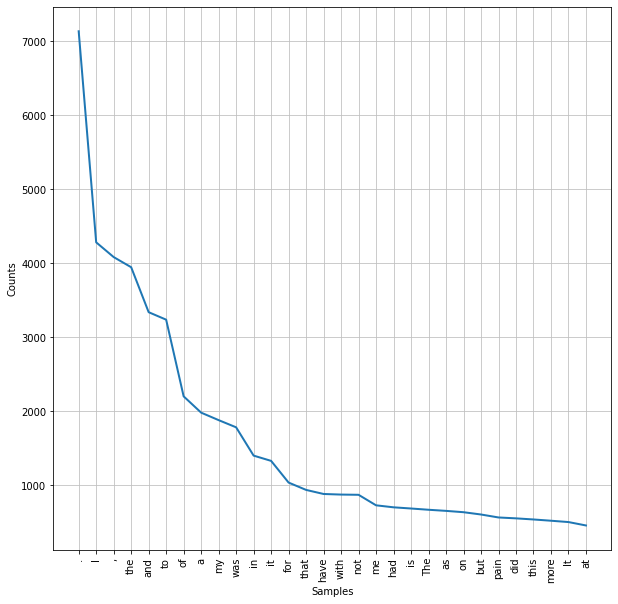

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
plt.figure(figsize=(10,10))
fdist.plot(30)

#### Removing Stop Words

In [20]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'over', 'theirs', 'why', 'were', 'me', 'she', 'under', 'him', 'won', 'our', 'it', 'other', 'being', 'can', 'whom', 'into', 'does', 'than', "don't", 'am', 'yours', 'is', "weren't", 'too', 'only', 'when', 'because', 'yourselves', 'by', 'do', 'very', 'has', 'against', "that'll", "you'd", 'be', 'where', 'same', 'now', 'some', 'did', "won't", 'who', 'below', 'weren', 'haven', 'during', 'while', "hadn't", 'any', 'a', 'have', 's', 'didn', 'i', 'needn', 'both', 'from', 'of', "shouldn't", "aren't", 'you', 'shan', 'after', 'the', 'her', "wouldn't", 'about', 'ma', 'd', 'these', 'between', 'so', 'most', 'ours', 'all', "mightn't", 'out', 'not', 'll', 'herself', "you've", 'mustn', "you're", 'his', 'hers', 'at', "she's", 'again', "shan't", 'then', 'how', "doesn't", "wasn't", 'in', 'what', 'each', 'don', 'up', 've', 'here', 're', 'he', 'those', 'doing', 'myself', "should've", 'couldn', 'above', 'once', 'to', 'wouldn', "didn't", 'ain', 'm', 'such', 'and', 'down', 'there', 'as', 'isn', 'few', 'more', "

In [21]:
filtered_review=[]
for w in total_words:
    if w not in stop_words:
        filtered_review.append(w)
print("Filterd Words:",filtered_review[:20])

Filterd Words: ['slowed', 'progression', 'left', 'ventricular', 'dysfunction', 'overt', 'heart', 'failure', 'alone', 'agents', 'managment', 'hypertension', 'mangagement', 'congestive', 'heart', 'failur', 'Although', 'type', 'birth', 'control']


In [22]:
print(len(total_words))
print(len(filtered_review))

126845
82365


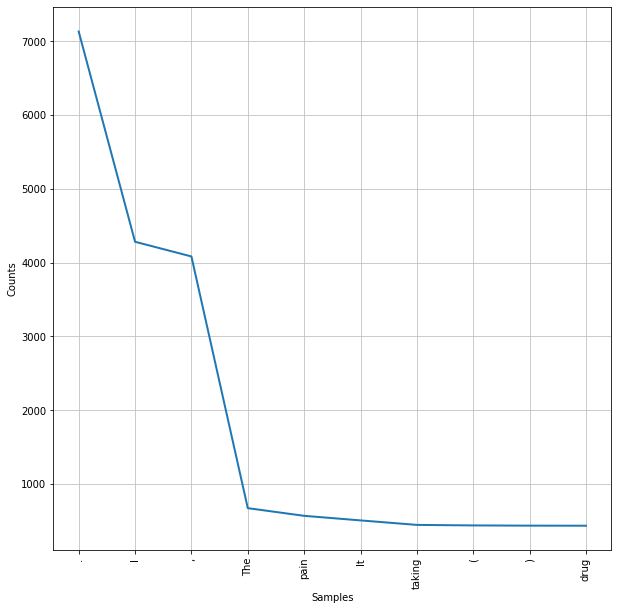

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [23]:
fdist = FreqDist(filtered_review)
plt.figure(figsize=(10,10))
fdist.plot(10)

Why are words like The, It, -, (, ) appearing above?

#### Stemming

In [24]:
ps = PorterStemmer()

stemmed_review=[]
for w in filtered_review:
    stemmed_review.append(ps.stem(w))

print(stemmed_review)

['slow', 'progress', 'left', 'ventricular', 'dysfunct', 'overt', 'heart', 'failur', 'alon', 'agent', 'manag', 'hypertens', 'mangag', 'congest', 'heart', 'failur', 'although', 'type', 'birth', 'control', 'con', 'pro', ',', 'help', 'cramp', '.', 'It', "'s", 'also', 'effect', 'prevent', 'pregnanc', '.', '(', 'along', 'use', 'condom', 'well', ')', 'I', 'use', 'cramp', 'badli', 'would', 'leav', 'ball', 'bed', 'least', '2', 'day', '.', 'the', 'ponstel', "n't", 'take', 'pain', 'away', 'complet', ',', 'take', 'edg', 'much', 'normal', 'activ', 'possibl', '.', 'definit', 'miracl', 'medic', '!', '!', 'the', 'acid', 'reflux', 'went', 'away', 'month', 'day', 'drug', '.', 'the', 'heartburn', 'start', 'soon', 'I', 'stop', 'take', '.', 'So', 'I', 'began', 'treatment', '.', '6', 'month', 'pass', 'I', 'stop', 'take', '.', 'the', 'heartburn', 'came', 'back', ',', 'seem', 'wors', 'even', '.', 'the', 'doctor', 'said', 'I', 'tri', 'anoth', '6', 'month', 'treatment', '.', 'I', ',', 'exact', 'thing', 'happen'

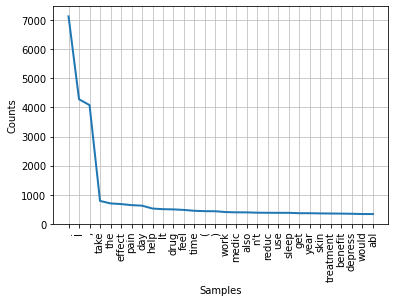

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [25]:
fdist = FreqDist(stemmed_review)
fdist.plot(30)

#### Lemmatiziation

In [26]:
lemmatizer = WordNetLemmatizer() 

In [27]:
print("movies:", lemmatizer.lemmatize("movies")) 
print("collecting:", lemmatizer.lemmatize("collecting")) 
print("collection:", lemmatizer.lemmatize("collection")) 
print("collections:", lemmatizer.lemmatize("collections")) 

movies: movie
collecting: collecting
collection: collection
collections: collection


In [28]:
# comparing it with stemming 
print("movies:", ps.stem("movies")) 
print("collecting :", ps.stem("collecting")) 

movies: movi
collecting : collect


In [29]:
# we can also lemmatize our original reviews
lemmatized_review=[]
for w in filtered_review:
    lemmatized_review.append(lemmatizer.lemmatize(w))

# print(lemmatized_review)

['slowed', 'progression', 'left', 'ventricular', 'dysfunction', 'overt', 'heart', 'failure', 'alone', 'agent', 'managment', 'hypertension', 'mangagement', 'congestive', 'heart', 'failur', 'Although', 'type', 'birth', 'control', 'con', 'pro', ',', 'help', 'cramp', '.', 'It', "'s", 'also', 'effective', 'prevention', 'pregnancy', '.', '(', 'Along', 'use', 'condom', 'well', ')', 'I', 'used', 'cramp', 'badly', 'would', 'leave', 'balled', 'bed', 'least', '2', 'day', '.', 'The', 'Ponstel', "n't", 'take', 'pain', 'away', 'completely', ',', 'take', 'edge', 'much', 'normal', 'activity', 'possible', '.', 'Definitely', 'miracle', 'medication', '!', '!', 'The', 'acid', 'reflux', 'went', 'away', 'month', 'day', 'drug', '.', 'The', 'heartburn', 'started', 'soon', 'I', 'stopped', 'taking', '.', 'So', 'I', 'began', 'treatment', '.', '6', 'month', 'passed', 'I', 'stopped', 'taking', '.', 'The', 'heartburn', 'came', 'back', ',', 'seemed', 'worse', 'even', '.', 'The', 'doctor', 'said', 'I', 'try', 'anothe

### Feature Engineering for NLP

#### Vectorizing

In [30]:
# Convert a collection of text documents to a matrix of token counts
docs = review
vec = CountVectorizer(stop_words=None)
X = vec.fit_transform(docs)

df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
df

,00,000,02,05,09,10,100,1000,100mg,101,...,zone,zoning,zoster,zovirax,zpak,zyban,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
review

0       slowed the progression of left ventricular dys...
1       Although this type of birth control has more c...
2       I was used to having cramps so badly that they...
3       The acid reflux went away for a few months aft...
4       I think that the Lyrica was starting to help w...
                              ...                        
3102    Increased focus, attention, productivity. Bett...
3103      Emotions were somewhat blunted. Less moodiness.
3104                                                  ---
3105                 Controlled complex partial seizures.
3106    The drug Micardis did seem to alleviate my hig...
Name: benefitsReview, Length: 3107, dtype: object

In [33]:
# vec.get_feature_names()

['00',
 '000',
 '02',
 '05',
 '09',
 '10',
 '100',
 '1000',
 '100mg',
 '101',
 '102',
 '103',
 '104',
 '105',
 '10am',
 '10g',
 '10kg',
 '10lbs',
 '10mg',
 '10x',
 '11',
 '110',
 '115',
 '117',
 '12',
 '120',
 '1200',
 '122',
 '125mcg',
 '127',
 '128',
 '12hr',
 '12th',
 '13',
 '130',
 '131',
 '135',
 '138',
 '14',
 '140',
 '140lbs',
 '144',
 '14lbs',
 '14th',
 '15',
 '150',
 '150mg',
 '150mgs',
 '156',
 '15mg',
 '16',
 '160',
 '1600',
 '160bpm',
 '165',
 '17',
 '174',
 '18',
 '180',
 '185',
 '1850',
 '186',
 '19',
 '190',
 '198',
 '1990',
 '1992',
 '1994',
 '1997',
 '1998',
 '1999',
 '1hr',
 '1mg',
 '1st',
 '1x',
 '20',
 '200',
 '2000',
 '2001',
 '2002',
 '2003',
 '2006',
 '2007',
 '2008',
 '2009',
 '200mg',
 '20lbs',
 '20mg',
 '20s',
 '21',
 '212',
 '218',
 '22',
 '225',
 '23',
 '230',
 '237',
 '24',
 '240',
 '24hr',
 '24hrs',
 '25',
 '250',
 '250mg',
 '25mg',
 '26',
 '26mo',
 '27',
 '270',
 '28',
 '280',
 '29',
 '2days',
 '2nd',
 '2x',
 '2yrs',
 '30',
 '300',
 '300mg',
 '30mg',
 '30

#### TF-IDF

In [ ]:
# term frequency-inverse document frequency 
# Essentially, tf-idf normalizes the raw count of the document term matrix 
# And it represents how important a word is in the given document

In [ ]:
# using count vectorizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts= cv.fit_transform(review)

In [ ]:
type(text_counts)

In [ ]:
pd.DataFrame(text_counts)

In [ ]:
df = pd.DataFrame(text_counts.todense(),columns = cv.get_feature_names())
df

In [ ]:
df.columns

In [ ]:
# using tfidf vectorizer instead

In [ ]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(review)
text_tf.data

In [ ]:
# examine what type of object text_tf is
print(type(text_tf))
print(type(text_tf.data))

In [ ]:
def fn_tdm_df(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    vectorizer = CountVectorizer(**kwargs)
    x1 = vectorizer.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = vectorizer.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df



In [ ]:
fn_tdm_df(review).T

In [ ]:
def fn_tdm_tfidf(docs, xColNames = None, **kwargs):
    ''' create a term document matrix as pandas DataFrame
    with **kwargs you can pass arguments of CountVectorizer
    if xColNames is given the dataframe gets columns Names'''

    #initialize the  vectorizer
    tf = TfidfVectorizer(**kwargs)
    x1 = tf.fit_transform(docs)
    #create dataFrame
    df = pd.DataFrame(x1.toarray().transpose(), index = tf.get_feature_names())

    if xColNames is not None:
        df.columns = xColNames

    return df

In [ ]:
fn_tdm_tfidf(review).transpose()